# Building Data Genome Project 2.0
## Meters data quality visualization

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

import gc

In [2]:
path_raw = "..//data//meters//raw//"
path_anom = "..//data//meters//screening//anomalies//"

# Introduction

In this notebooks will be made visualizations showing availability and data quality (missing, zeros, outliers...).<br>
Outliers in the raw meters dataset were detected using the [Seasonal Hybrid ESD (S-H-ESD)](https://github.com/twitter/AnomalyDetection) developed by Twitter. This was implemented in R language, the process can be found [here](https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/04_Anomaly-detection.Rmd). The methodology used here is from _Forensically discovering simulation feedback knowledge from a campus energy information system_ [(Miller - Schlueter, 2015)](https://cargocollective.com/buildingdata/Forensic-Analysis-of-Campus-Dataset).<br>
The values for each hour will be changed into the following ordinal values:
* NaN -- 0
* 0 Values -- 1
* Outliers -- 2
* "Good Data" -- 3

# Functions

In [3]:
# This function is to plot each meter alone
def plotHeatmap(df, metername):
    numberofplots = 1
    fig = plt.figure(figsize=(10,15))
    #plt.rc('ytick', labelsize=yfont)

    # Get the data
    x = mdates.drange(df.columns[0], df.columns[-1] + dt.timedelta(hours=1), dt.timedelta(hours=1))
    #y = df.index
    y = np.linspace(1, len(df), len(df)+1)

    # Plot
    ax = fig.add_subplot(numberofplots, 1, 1)

    data = np.array(df)

    cmap = plt.get_cmap('Reds', 4)

    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True)

    cbaxes = fig.add_axes([0.13, 0.1, 0.77, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax = cbaxes)
    cbar.ax.tick_params(length = 0)
    tick_locator = ticker.MaxNLocator(nbins=3)
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label('Quality Metric')

    ax.axis('tight')

    # Set up as dates
    ax.xaxis_date()
    #ax.yaxis.set_ticks()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)

    ax.set_xlabel("Timeline", fontsize=16)
    ax.set_ylabel("Building", fontsize=16)
    ax.set_title(str(metername) +" Meter Quality Screening", fontdict={'fontsize':20},
)
    #plt.tight_layout()
    plt.subplots_adjust(bottom=0.17)
    
    return fig

In [4]:
# This function process all meters data automatically
def processData(metername):
    # load data
    df = pd.read_csv(path_raw + metername + ".csv") 
    # Transform timestamp to datetime object type
    df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S')
    
    # load anomalies df
    df_anom = pd.read_csv(path_anom + metername + "_anoms.csv")    
    # Transform timestamp to datetime object type
    df_anom["timestamp"] = pd.to_datetime(df_anom["timestamp"], format='%Y-%m-%d %H:%M:%S')
    # Remove timezone offset at the end of timestamp
    df_anom["timestamp"] = df_anom.timestamp.apply(lambda d: d.replace(tzinfo=None))
    
    # Outliers
    df_anom = df_anom.set_index("timestamp")
    outliers = df_anom.copy()
    
    # replace not null values with 2 (outliers)
    outliers[outliers.isna() == False] = 2
    
    # Set index and copy to replace values
    df_qm = df.set_index("timestamp").copy()
    
    # "Good data"
    df_qm[df_qm > 0] = 3
    
    # Zero values
    df_qm[df_qm <= 0] = 1
    
    # Update df with outliers data
    df_qm.update(outliers)
    
    # Fill na with 0
    df_qm.fillna(value=0, inplace=True)
    
    # Sort by quantity of "good data"
    df_qm = df_qm.T.loc[df_qm.T.sum(axis=1).sort_values().index]
    
    return(df_qm)

# One figure to subplot them all

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


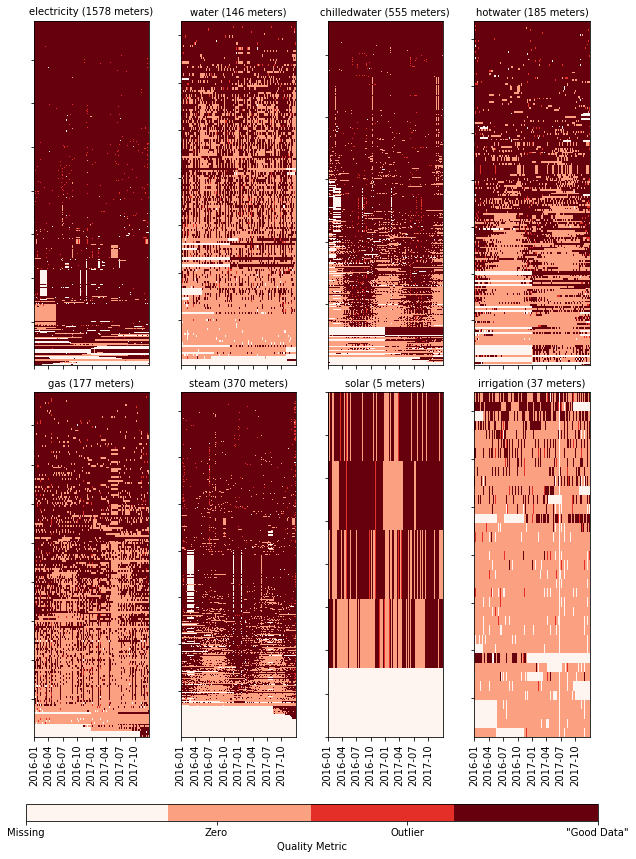

In [5]:
fig, axes = plt.subplots(2, 4, sharex = True, figsize=(8.27,11.69))
axes = axes.flatten()

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    
    df = processData(j)
    
    # Get the data
    x = mdates.drange(df.columns[0], df.columns[-1] + dt.timedelta(hours=1), dt.timedelta(hours=1))
    y = np.linspace(1, len(df), len(df)+1)
    
    # Plot
    ax = axes[i]
    data = np.array(df)
    cmap = plt.get_cmap('Reds', 4)
    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True)
    # Axis
    ax.axis('tight')  
    ax.xaxis_date() # Set up as dates
    ax.tick_params("x", labelrotation=90)
    ax.set_yticklabels([])
    ax.set_title(j + " (" + str(int(max(y))) + " meters)", fontdict={'fontsize':10})

# Color bar  
cbaxes = fig.add_axes([0.025, 0.02, 0.96, 0.02]) 
cbar = fig.colorbar(qmesh, ax=ax, ticks=[0,1,2,3], orientation='horizontal', cax = cbaxes)
cbar.ax.set_xticklabels(['Missing', 'Zero', 'Outlier', '"Good Data"'])
cbar.set_label('Quality Metric')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

In [6]:
fig.savefig("..\\figures\\dataQuality_all.jpg", dpi=300, bbox_inches='tight')

# Bibliography

- Miller, Clayton & Schlueter, Arno. (2015). Forensically discovering simulation feedback knowledge from a campus energy information system. 10.13140/RG.2.1.2286.0964. 